In [1]:
import numpy as np
import lmdb
import sys
caffe_root = '..'
sys.path.insert(0,caffe_root+'/python')
import caffe
import os
import cv2
from scipy import misc
from os.path import expanduser
home_dir = expanduser("~")
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import glob

In [2]:
# %load ../models/coco-baseline/solve.py
from __future__ import division
# make a bilinear interpolation kernel
# credit @longjon
def upsample_filt(size):
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
# set parameters s.t. deconvolutional layers compute bilinear interpolation
# N.B. this is for deconvolution without groups
def interp_surgery(net, layers):
    for l in layers:
        m, k, h, w = net.params[l][0].data.shape
        if m != k:
            print 'input + output channels need to be the same'
            raise
        if h != w:
            print 'filters need to be square'
            raise
        filt = upsample_filt(h)
        net.params[l][0].data[range(m), range(k), :, :] = filt


Set parameters of training:

In [ ]:
# continuing or starting training
cont = False; cont_itr = 30000
total_itr = 60000
loss_save_interval = 100
net_save_interval = 2000
experiment_name = 'coco-600-mirror-dsn'
caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver(caffe_root+'/models/'+experiment_name+'/solver.prototxt')


In [17]:
interp_layers = [k for k in solver.net.params.keys() if 'up' in k]
interp_surgery(solver.net, interp_layers)

In [18]:
if cont:
    solver.net.copy_from(caffe_root+'/models/'+experiment_name+'/'+experiment_name+'_'+str(cont_itr)+'.caffemodel')
    niter = range(cont_itr+1, total_itr)
    train_loss = np.load(caffe_root+'/models/'+experiment_name+'/'+'train_loss.npy')
else:
    solver.net.copy_from(caffe_root+'/models/vgg/vgg16_fully_conv.caffemodel')
    niter = range(total_itr)
    train_loss = np.zeros(len(niter))

iter 0, loss=7354550.000000


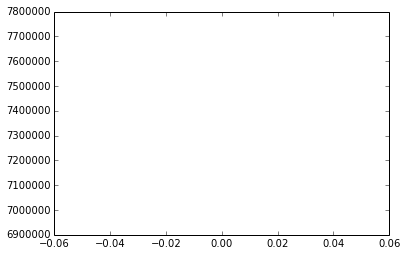

In [ ]:
for it in niter:
    solver.step(1)  # SGD by Caffe
    # store the train loss
    train_loss[it] = solver.net.blobs['loss_conv3_3'].data + \
                    solver.net.blobs['loss_conv4_3'].data + \
                    solver.net.blobs['loss_conv5_3'].data + \
                    solver.net.blobs['loss_fc7'].data + \
                    solver.net.blobs['loss_fuse'].data                    
    if it % loss_save_interval == 0:
        clear_output()
        print 'iter %d, loss=%f' % (it, train_loss[it])
        plt.plot(train_loss[:it+1])
        plt.show()
        plt.savefig(caffe_root+'/models/'+experiment_name+'/'+'loss_curve.png')
        np.save(caffe_root+'/models/'+experiment_name+'/'+'train_loss.npy',train_loss)
    if it % net_save_interval == 0: 
        solver.net.save(caffe_root+'/models/'+experiment_name+'/'+experiment_name+'_'+str(it)+'.caffemodel')
print 'done'

In [4]:
net = solver.net

In [7]:
net.blobs['data'] = np.random.rand(1,3,640,640).astype(np.float32)
net.blobs['label'] = np.random.rand(1,1,640,640).astype(np.float32)

In [13]:
net.forward()

<bound method Net._Net_forward_all of <caffe._caffe.Net object at 0x7f65f4722398>>

In [11]:
net.backward()

{}